# Assignment 1: resistor detection

In [1]:
# Imports
import os # Module to access Operating System
import cv2 # Module for computer vision algorithms
import numpy as np # Module for matrix operations and linear algebra
import pandas as pd # Module for dataset handling
from sklearn import svm # Module that implements a Support Vector Machine (Machine Learning algorithm)
import matplotlib.pyplot as plt # Module for plotting
from mpl_toolkits.mplot3d import Axes3D # Module for 3D plotting
from sklearn.preprocessing import LabelEncoder # Module to encode string labels

In [2]:
# This function decodes the color encodings into a resistor value
def decode(bands):

    # Init
    color = ['k', 'z', 'r', 'o', 'y','g', 'b', 'v', 'x', 'w'] # [black, brown, red, orange, yellow, green, blue, violet, gray, white]
    value = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    ohm, multiplier, unit = '', '', ' ohms'

    # Decode third band
    for i in range(len(color)):
        if bands[2] == color[i]:
            multiplier = 10**value[i]

    # Decode secodn and first band
    for i in range(len(color)):
        if bands[1] == color[i]:
            bands_one = value[i]
        if bands[0] == color[i]:
            bands_zero = value[i]

    # Calculate result
    res = int(str(bands_zero) + str(bands_one))*multiplier

    # Convert
    if res >= 1000000:
        res = str(res/1000000)
        if res[-1] == '0':
            res = res[0:-2] + 'M'
        else: res = res + 'M'
    elif res >= 1000:
        res = str(res/1000)
        if res[-1] == '0':
            res = res[0:-2] + 'k'
        else: res = res + 'k'

    # Finish
    ohm = str(res) + unit 

    return ohm

In [3]:
# This function has an image as input and outputs the mean HSV-values of the three color bands in the image
def extract_color_bands(image):

	# Convert to gray to threshold background
	image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# Threshold background
	_, threshed = cv2.threshold(image_gray, 254, 255, cv2.THRESH_BINARY_INV)

	# The kernel is chosen to be larger than the sticks, and smaller than the resistor
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

	# We open the image in order to remove the sticks
	morphed_open = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kernel)

	# Find contour of resistor
	contours = cv2.findContours(morphed_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

	# Get largest contour
	maxcontour = max(contours, key=cv2.contourArea)

	# Get minimal area rectangle
	rect = cv2.minAreaRect(maxcontour)

	# Get rectangle properties
	angle = rect[2]
	rows, cols = image.shape[0], image.shape[1]

	# Rotate image
	M = cv2.getRotationMatrix2D((rect[0][0],rect[0][1]), angle-90, 1)
	image_aligned = cv2.warpAffine(image,M,(cols,rows))

	# Rotate bounding box 
	box = cv2.boxPoints((rect[0], rect[1], angle))
	pts = np.intp(cv2.transform(np.array([box]), M))[0]    
	pts[pts < 0] = 0

	# Cropping
	image_cropped = image_aligned[pts[0][1]:pts[3][1], pts[0][0]:pts[2][0]]

	# Get HSV calibration params 
	hsvfile1 = np.load('./data/resistor_data/demo3_hsv_resistor.npy')
	hsvfile2 = np.load('./data/resistor_data/demo3_hsv_background.npy')

	# Convert image to HSV
	hsv = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2HSV)

	# Remove area in between color bands
	mask1 = cv2.bitwise_not(cv2.inRange(hsv, np.array([hsvfile1[0], hsvfile1[2], hsvfile1[4]]), np.array([hsvfile1[1], hsvfile1[3], hsvfile1[5]])))
	mask2 = cv2.inRange(hsv, np.array([hsvfile2[0], hsvfile2[2], hsvfile2[4]]), np.array([hsvfile2[1], hsvfile2[3], hsvfile2[5]]))
	mask = cv2.bitwise_and(mask1, mask2)

	# Morphological transformations to remove sticks
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
	morphed_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
	mask = cv2.morphologyEx(morphed_open, cv2.MORPH_CLOSE, kernel)
	
	# Find the three largest contours of the color bands
	contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

	# Get three largest contours
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[0:3]

	# Sort contours from left to right
	sorted_contours = sorted(largest_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

	# Iterate over three contours
	color_bands = []
	for ctr in sorted_contours:

		# Get roi
		x,y,w,h = cv2.boundingRect(ctr)
		roi = hsv[y+10:y+h-10, x+5:x+w-5]

		# Get hsv
		roi_h = [i for i in roi[:,:,0].ravel() if i != 0]  
		roi_s = [i for i in roi[:,:,1].ravel() if i != 0]  
		roi_v = [i for i in roi[:,:,2].ravel() if i != 0]  

		# Get means of HSV data
		mean_hsv = [np.mean(roi_h), np.mean(roi_s), np.mean(roi_v)]

		# Predict
		color_bands.append(mean_hsv)

	return color_bands


## Data analysis


In [4]:
# Download data
if not os.path.exists('data/resistor_data'):
    !wget -q --no-check-certificate -O dataset.zip "https://kuleuven-my.sharepoint.com/:u:/g/personal/matthias_deryck_kuleuven_be/EQYSStulyl5CrPuiERAMpEsB0RMf4164Ng4zPzCtcDRcOA?e=K48wUZ&download=1"
    !unzip -q dataset.zip -d data
    !rm dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find either dataset.zip or dataset.zip.zip.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In this step, we will briefly analyze the data and show some data samples.

In [5]:
# Get the file names of all images in the dataset (data/resistor_data/images)
image_paths = os.listdir('./data/resistor_data/images/')

# Print results
print(f'There are {len(image_paths)} images in the dataset.')
print(f'\nThese are the file names of the first five images: {[path_name for path_name in image_paths[0:5]]}')
print('\nThe last three letters of the file names denote the code of the three color bands of the resistor in the image.')
print('\nThe color bands are encoded as follows: [k, z, r, o, y, g, b, v, x, w] -> [black, brown, red, orange, yellow, green, blue, violet, gray, white]')

There are 200 images in the dataset.

These are the file names of the first five images: ['100_zkr.jpg', '101_bxz.jpg', '102_bxz.jpg', '103_bxz.jpg', '104_bxz.jpg']

The last three letters of the file names denote the code of the three color bands of the resistor in the image.

The color bands are encoded as follows: [k, z, r, o, y, g, b, v, x, w] -> [black, brown, red, orange, yellow, green, blue, violet, gray, white]


File name: 100_zkr.jpg


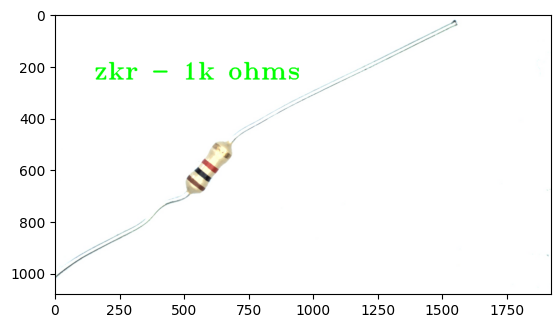

File name: 101_bxz.jpg


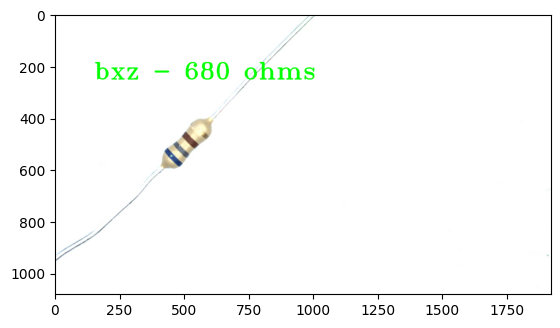

File name: 102_bxz.jpg


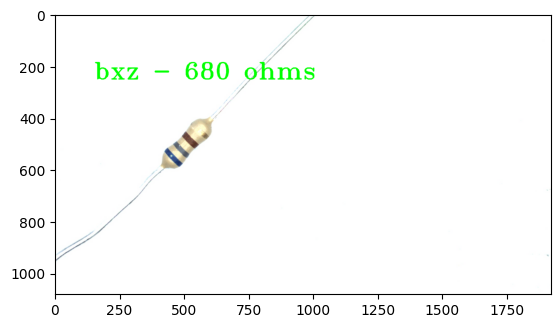

File name: 103_bxz.jpg


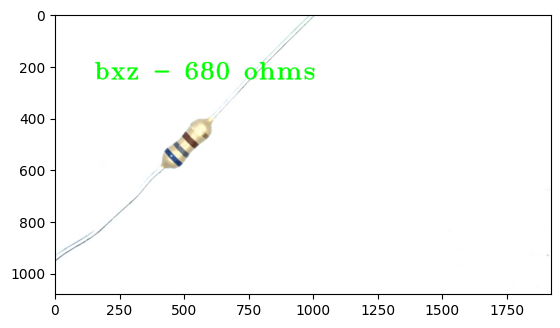

File name: 104_bxz.jpg


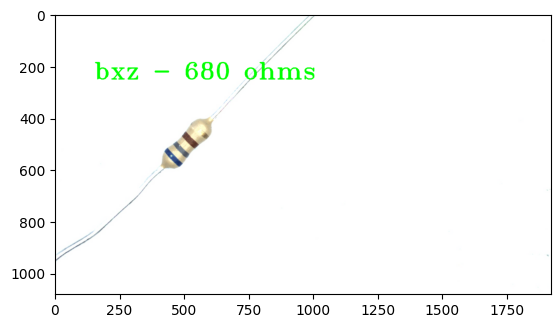

In [6]:
# Loop over the first five images
for path in image_paths[0:5]:
	
	# Read image
	image = cv2.imread('./data/resistor_data/images/' + path)

	# Extract the ground truth label from the file name
	label = path.split('_')[-1][0:3]

    # Plot the label on the image in green
	cv2.putText(image, text=label + " - " + decode(label), org=(150, 250), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=3, color=(0, 255, 0),thickness=3)
	
	# Show image
	print(f'File name: {path}')
	plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
	plt.show()

## Data preprocessing



In this step, we will perform several image processing steps in order to extract the neccesary features from the image in order to be able to classify it in the right class. The features that we need to distinguish all images are the three color codes of the color bands. We ommit the tolerance band for simplicity. First, we read the image and show it. OpenCV reads images in BGR (Blue, Green, Red) format by default. 

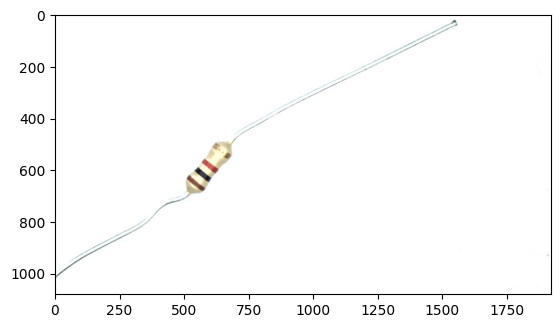

In [7]:
# Select the first image
image = cv2.imread('./data/resistor_data/images/' + image_paths[0])

# Extract the ground truth label from the file name
label = image_paths[0].split('_')[-1][0:3]

# Show image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In the next step, we convert the BGR-image to grayscale and threshold the saturated (value 255) background. 

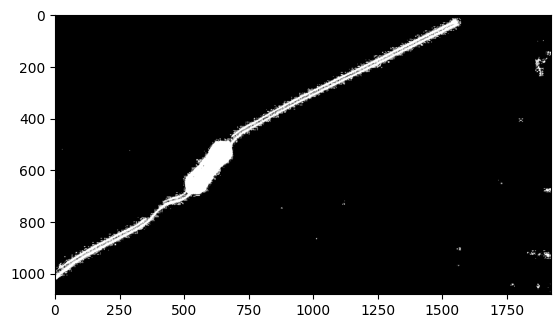

In [8]:
# Convert to gray to threshold background
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold background
_, threshed = cv2.threshold(image_gray, 254, 255, cv2.THRESH_BINARY_INV)

# Show threshed mask
plt.imshow(threshed, cmap='gray')
plt.show()

To remove the sticks, we use some morphological transformations that remove all white elements that are smaller than the kernel. To do this, we define a kernel that is smaller than the core of the resistor which we want to keep, and larger than the elements we want to remove. In our case this is a rectangular kernel with size 20x20 pixels.

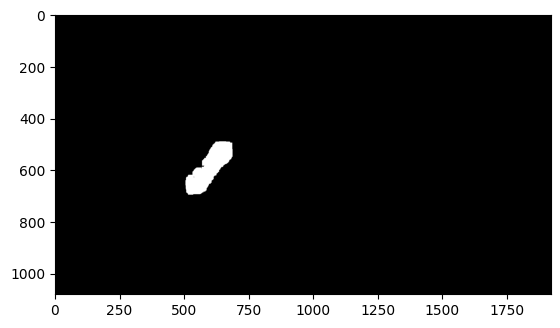

In [9]:
# The kernel is chosen to be larger than the sticks, and smaller than the resistor
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))

# We open (first closing, then dilating) the image in order to remove the sticks
morphed_open = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kernel)

# Show opened mask
plt.imshow(morphed_open, cmap='gray')
plt.show()

We want to find the bounding box of the resistor. Using the binary mask, we find the contour of the resistor and obtain its bounding box. 

There is 1 contour found in the binary image. The contour has an area of 18045.5 pixels

A minimum area rectangle is found with an upper right corner on (x, y) = (595.5399780273438, 593.176513671875), height and width of (91.90191650390625, 262.4352111816406) in pixels, 
and an orientation of 39.214447021484375 degrees with the horizontal


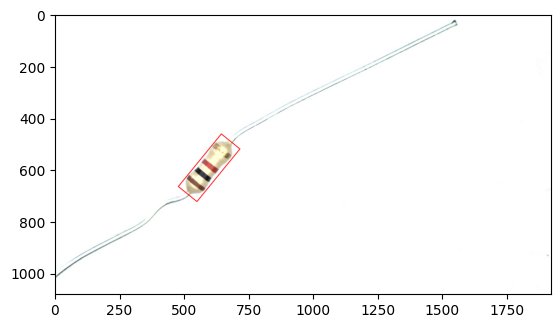

In [10]:
# Find contour of resistor
contours = cv2.findContours(morphed_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

# Print results
print(f'There is {len(contours)} contour found in the binary image. The contour has an area of {cv2.contourArea(contours[0])} pixels')

# Get minimal area rectangle
rect = cv2.minAreaRect(contours[0])

# Print results
print(f'\nA minimum area rectangle is found with an upper right corner on (x, y) = {rect[0]}, height and width of {rect[1]} in pixels, \nand an orientation of {rect[2]} degrees with the horizontal')

# Draw bounding box
debug_image = cv2.drawContours(image.copy(),[np.intp(cv2.boxPoints(rect))], 0, (0,0,255), 2)

# Show bounding box
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

Next, we will align the resistor with the horizontal for further analysis. To do this, we use the orientation of the bounding box and transform the image using this orientation.

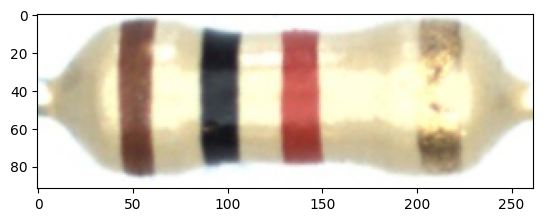

In [11]:
# Get bounding box orientation
angle = rect[2]

# Get width and height of the image
rows, cols = image.shape[0], image.shape[1]

# Get the rotation matix to rotate the bounding box to the horizontal
M = cv2.getRotationMatrix2D((rect[0][0],rect[0][1]), angle-90, 1)

# Apply the rotation matrix to rotate the image
image_aligned = cv2.warpAffine(image, M, (cols, rows))

# Also rotate the bounding box 
pts = np.intp(cv2.transform(np.array([cv2.boxPoints((rect[0], rect[1], angle))]), M))[0]    
pts[pts < 0] = 0

# Crop the rotated image using the rotated bounding box to obtain the horizontal resistor core
image_cropped = image_aligned[pts[0][1]:pts[3][1], pts[0][0]:pts[2][0]]

# Show cropped image
plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()


Next, we will detect the color bands using a combination of two thresholding masks. The HSV threshold values were calibrated earlier and the threshold values for the background and the resistor core were saved in numpy arrays (.npy files).

The HSV threshold values to threshold the resistor core are: [ 15  35   0 255   0 255], where the first three values are the lower HSV values and the last three the upper HSV values
The HSV threshold values to threshold the background are: [  0 179   0 255   0 248], where the first three values are the lower HSV values and the last three the upper HSV values

Resistor core removed:


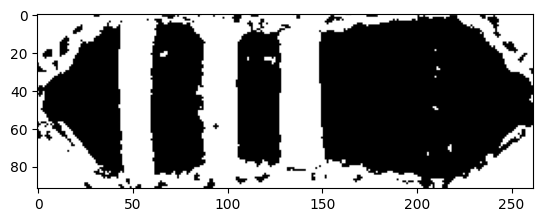

Background removed:


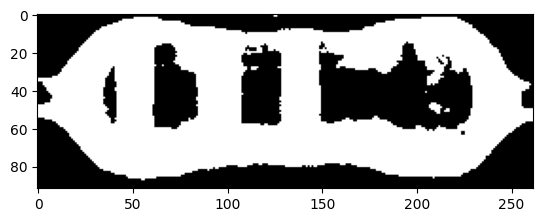

Combined effect:


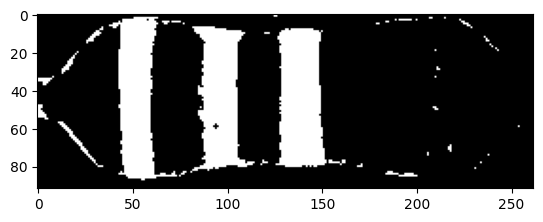

Result after morphology:


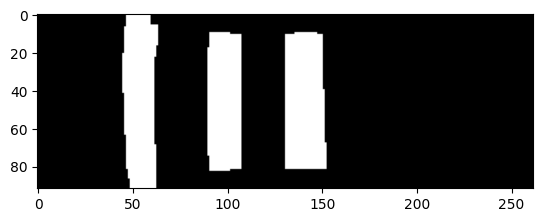

In [13]:
# Get HSV calibration params 
hsvfile1 = np.load('./data/resistor_data/demo3_hsv_resistor.npy')
hsvfile2 = np.load('./data/resistor_data/demo3_hsv_background.npy')

# Print results
print(f'The HSV threshold values to threshold the resistor core are: {hsvfile1}, where the first three values are the lower HSV values and the last three the upper HSV values')
print(f'The HSV threshold values to threshold the background are: {hsvfile2}, where the first three values are the lower HSV values and the last three the upper HSV values')

# Convert image to HSV to simplify thresholding
hsv = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2HSV)

# Apply HSV thresholding on the resistor core to remove the area in between color bands
mask1 = cv2.bitwise_not(cv2.inRange(hsv, np.array([hsvfile1[0], hsvfile1[2], hsvfile1[4]]), np.array([hsvfile1[1], hsvfile1[3], hsvfile1[5]])))

# Show mask 1
print("\nResistor core removed:")
plt.imshow(mask1, cmap='gray')
plt.show()

# Apply HSV thresholding on the resistor core to remove the background
mask2 = cv2.inRange(hsv, np.array([hsvfile2[0], hsvfile2[2], hsvfile2[4]]), np.array([hsvfile2[1], hsvfile2[3], hsvfile2[5]]))

# Show mask 2
print("Background removed:")
plt.imshow(mask2, cmap='gray')
plt.show()

# Combine effects
mask = cv2.bitwise_and(mask1, mask2)

# Show cropped image
print("Combined effect:")
plt.imshow(mask, cmap='gray')
plt.show()

# Morphological transformations to remove remaining white noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
morphed_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(morphed_open, cv2.MORPH_CLOSE, kernel)

# Show cropped image
print("Result after morphology:")
plt.imshow(mask, cmap='gray')
plt.show()

Using the HSV thresholds and the morphological transformations, we managed to extract the color bands from the image. In the next step we will generate three cropped images of only the color bands. 

There are 3 contours found in the binary image.


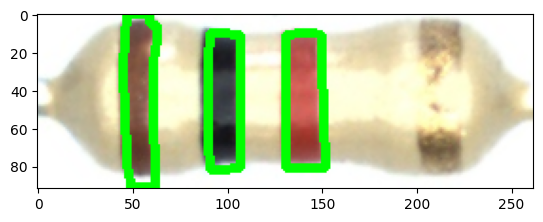

In [14]:
# Find the three largest contours of the color bands
contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

# Print results
print(f'There are {len(contours)} contours found in the binary image.')

# Sort contours from left to right so that it matches our encodings
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Draw the contours on the image
image_cropped = cv2.drawContours(image_cropped.copy(), sorted_contours, -1, (0,255,0), 3)

# Show cropped image
plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
plt.show()

Contour 1 has a mean HSV-value of [8.114197530864198, 116.11728395061728, 125.4320987654321]


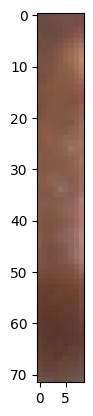

Contour 2 has a mean HSV-value of [114.47030878859857, 38.764845605700714, 53.87971698113208]


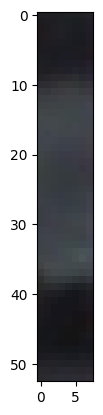

Contour 3 has a mean HSV-value of [2.4292845257903495, 152.4551282051282, 191.09134615384616]


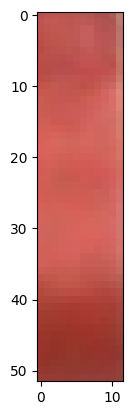

In [15]:
# Iterate over the three contours
color_bands = []
for j, ctr in enumerate(sorted_contours):

    # Get the bounding box rond the contour
    x,y,w,h = cv2.boundingRect(ctr)

    # Crop the image (RGB and HSV) to the bounding box (and even a bit smaller to be sure that we only capture the pure color band)
    roi_rgb = image_cropped[y+10:y+h-10, x+5:x+w-5]
    roi_hsv = hsv[y+10:y+h-10, x+5:x+w-5]

    # Get the HSV-values of all pixels of the color band
    roi_h = [i for i in roi_hsv[:,:,0].ravel() if i != 0]  
    roi_s = [i for i in roi_hsv[:,:,1].ravel() if i != 0]  
    roi_v = [i for i in roi_hsv[:,:,2].ravel() if i != 0]  

    # Get means of the HSV-values for all pixels in order to obtain one mean HSV value for the whole color band
    mean_hsv = [np.mean(roi_h), np.mean(roi_s), np.mean(roi_v)]

    # Add to data
    color_bands.append(mean_hsv)

    # Print results
    print(f'Contour {j+1} has a mean HSV-value of {mean_hsv}')

    # Show cropped image
    plt.imshow(cv2.cvtColor(roi_rgb, cv2.COLOR_BGR2RGB))
    plt.show()

Now we have a matrix with the HSV-values of the three color bands. This is the core information that we need for the image in order to be able to classify it properly. The HSV-values of the three color bands are the essential features that we need. To visualize this, we will plot is in a 3D scatterplot. The plot shows three dots in a 3D space which represents our image. Every image in our dataset can be represented using three dots. All dots of all images represents the full dataset on which we can train a classifier that learns how to classify images in resistor values. 

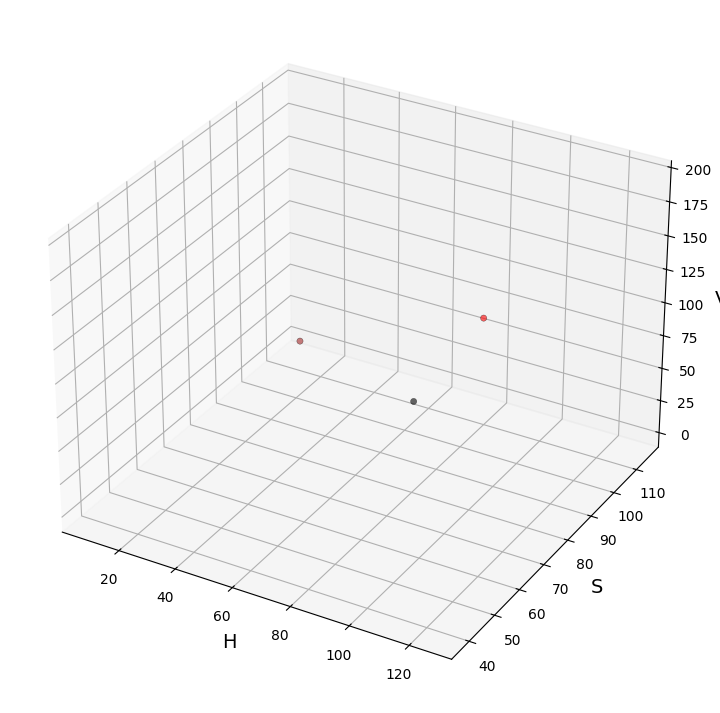

In [16]:
# Scatterplot
colors = {'x':'gray','r':'red','z':'brown','k':'black','b':'blue','v':'magenta','g':'green'}
c = list(map(lambda x: colors[str(x)], list(label)))
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(color_bands[:][0], color_bands[:][1], color_bands[:][2], c=c, alpha=.6, edgecolor='k', lw=0.3)
ax.set_xlabel('H', fontsize=14)
ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)
plt.show()

## Model training

A dataset is available that performd the image processing steps from above on all images in the dataset. We can load it and visualize it in the scatterplot. We see that we can define some clusters. These clusters represent the different colors that are present in our dataset (red, brown, black, gray, violet, and blue). It is visible that these clusters are easily separable and that no points overlap, which would make classification harder. It is perfectly possible to separate all clusters using linear planes in the 3D space. This is an indication that the chosen features (HSV-values) are very good features to classify resistors. In a last step, we convert the classes, which are strings, to integers for proper training.

The loaded Pandas DataFrame looks like (only the first five entries): 

             H           S           V Class
0    8.506250  115.820312  130.956250     z
1  118.039286   33.105357   54.566071     k
2    2.000000  151.955245  188.532867     r
3  109.009950  144.184080  133.976119     b
4  107.198276   36.339655  123.565517     x

The encoded Pandas DataFrame looks like (only the first five entries): 

             H           S           V  Class
0    8.506250  115.820312  130.956250      5
1  118.039286   33.105357   54.566071      1
2    2.000000  151.955245  188.532867      2
3  109.009950  144.184080  133.976119      0
4  107.198276   36.339655  123.565517      4

The dataset has a column for the H-, S-, and V-values of each row (representing one color band), as well as a column for the class of that color band.


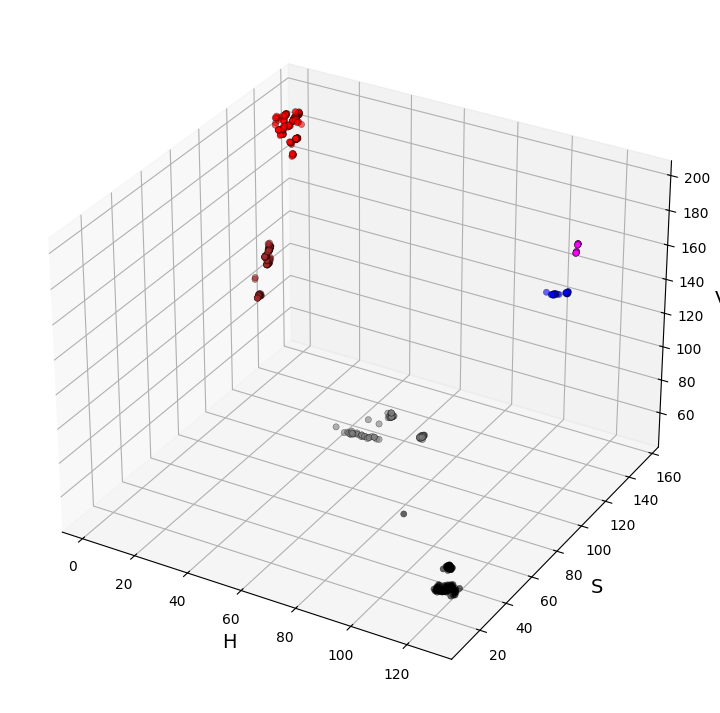

In [17]:
# Load data from CSV in a Pandas DataFrame
df = pd.read_csv("./data/resistor_data/color_data.csv")

# Define a mapping for the color encoding
c = df['Class'].map({'x':'gray','r':'red','z':'brown','k':'black','b':'blue','v':'magenta','g':'green'})

# Print results
print(f'The loaded Pandas DataFrame looks like (only the first five entries): \n\n {df.head()}')

# Encode categorical labels to integers
labelencoder= LabelEncoder() 
df['Class'] = labelencoder.fit_transform(df['Class'])

# Print results
print(f'\nThe encoded Pandas DataFrame looks like (only the first five entries): \n\n {df.head()}')
print('\nThe dataset has a column for the H-, S-, and V-values of each row (representing one color band), as well as a column for the class of that color band.')

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.H, df.S, df.V, c=c, alpha=.6, edgecolor='k', lw=0.3)
ax.set_xlabel('H', fontsize=14)
ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)
plt.show()

Now we can proceed to the training of the SVM. To do this, we extract the inputs (HSV-values) and output (Class) from the dataset and give it to the model. 

In [18]:
# Define the Support VEctor Machine model
model = svm.SVC()

# Define the inputs and outputs of the model
inputs = df[['H', 'S', 'V']].values
output = df['Class'].values

# Train the model on the dataset
model.fit(inputs, output)

SVC()

## Model validation

In this last step we will loop over all images in the dataset, extract the color bands using image processing, feeding the extracted HSV-values to the trained SVM model, and comparing the predicted result with the ground truth label. 

In [19]:
# Count number of correctly predicted samples
correct = 0

# Loop over every image in the dataset
for i in os.listdir('./data/resistor_data/images/'):

	# Read image
	image = cv2.imread('./data/resistor_data/images/' + path)

	# Extract the ground truth label from the file name
	label = path.split('_')[-1][0:3]

	# Extract color bands (this function implements the image processing steps that we defined earlier)
	bands = extract_color_bands(image)

	# Iterate over all three color bands and add the predicted class string to the final prediction
	prediction = ''
	for j, band in enumerate(bands):

		# Predict the color label of the color band
		pred = model.predict([band])

		# Convert the ineger encoding to the class string
		prediction += labelencoder.inverse_transform(pred)[0]

	# If the predicted label is equal to the ground truth label, count it
	if prediction == label: correct += 1

Finally, we can calculate the accuracy of our model which is the number of correctly predicted samples divided by the total number of samples. 

In [20]:
# Get total number of samples
total = len(os.listdir("./data/resistor_data/images"))

# Print results
print(f'There are {total} samples in the dataset')
print(f'\n{correct} samples are correctly classified')
print(f'\nThe accuracy of the system is {(correct/total)*100}%')

There are 200 samples in the dataset

200 samples are correctly classified

The accuracy of the system is 100.0%
